---
### Invert with regularization.
Please check the original paper:\
[Felipe A. Bulat, Tim Heaton-Burgess, Aron J. Cohen, and Weitao Yang, J. Chem. Phys. 127, 174101 (2007)](https://aip.scitation.org/doi/full/10.1063/1.2800021?casa_token=-ZgE4QLD_g0AAAAA%3AEKtFcuAPeo8_BGf_3CHsaCfPBletRKQgCgwE87XnpcJzZ1x_TPdeqDTltYzC9Uj9rqcukhbtOgAlhA)\
[Tim Heaton-Burgess, Felipe A. Bulat, and Weitao Yang, PRL 98, 256401 (2007)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.98.256401)

In [2]:
import psi4
import matplotlib.pyplot as plt
import numpy as np

psi4.set_options({"save_jk" : True})
psi4.set_memory(int(2.50e9))
psi4.core.clean()

import n2v
 
import matplotlib as mpl
mpl.rcParams["font.size"] = 11
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["axes.edgecolor"] = "#eae8e9" 

In [4]:
Ne = psi4.geometry( 
""" 
0 1
Ne
noreorient
nocom
units bohr
symmetry c1
""" )

psi4.set_options({"reference" : "rhf"})  # Spin-Restricted

# IMPORTANT NOTE: psi4.energy does not update cc densities. So we calculate dipole momentes instead.
wfn = psi4.properties("ccsd/cc-pcvdz",  return_wfn=True, molecule=Ne, property=['dipole'])[1]

# Build inverter and set target
ine = n2v.Inverter.from_wfn(wfn, pbs="cc-pcvqz")

#### Result without regularization

In [6]:
# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
ine.invert("PDECO", opt_max_iter=500, opt_method="BFGS", gtol=1e-6,
           guide_components="fermi_amaldi")

4-AO-Overlap tensor will take about 0.000013 GB.
Optimization Successful within 222 iterations! |grad|=1.85e-06.


In [9]:
x = np.linspace(-5,5,101)
y = np.zeros_like(x)
z = np.zeros_like(x)
grid = np.array([x,y,z])

vH = ine.eng.grid.esp(Da=ine.Dt[0], Db=ine.Dt[1], grid=grid)[1]
vFA = (1-1/(ine.nalpha + ine.nbeta)) * vH

vrest = ine.eng.grid.ao(ine.v_pbs, grid=grid, basis=ine.eng.pbs)
vxc = vFA + vrest - vH

According to the two paper cited above, a term is defined for this
$$
P(\lambda) = \lambda \frac{\|v_{pbs}(\lambda)\|^2}{N_{error}^{\lambda} - N_{error}^{\lambda=0}},
$$
where $N_{error}=\int dr (n - n_{in})^2$.

In [11]:

lambda_list, P, error = ine.find_regularization_constant_pdeco(opt_max_iter=100, 
                                                      opt_method="BFGS", gtol=1e-4,
                                                      lambda_list=10 ** np.linspace(-1,-7,21))
print("lambda:\n", lambda_list)
print("P:\n", P)

lambda:
 [1.00000000e-01 5.01187234e-02 2.51188643e-02 1.25892541e-02
 6.30957344e-03 3.16227766e-03 1.58489319e-03 7.94328235e-04
 3.98107171e-04 1.99526231e-04 1.00000000e-04 5.01187234e-05
 2.51188643e-05 1.25892541e-05 6.30957344e-06 3.16227766e-06
 1.58489319e-06 7.94328235e-07 3.98107171e-07 1.99526231e-07
 1.00000000e-07]
P:
 [  0.23965934   0.40562909   0.71244688   1.31433239   2.50948987
   4.83617086   9.11546465  15.69668145  21.92200037  21.77975413
  21.23473673  23.2063471   10.03488358  21.66005049 125.86246337
 141.29165685  60.34353976   9.76632105   5.27812036   3.42684602
  36.94844878]


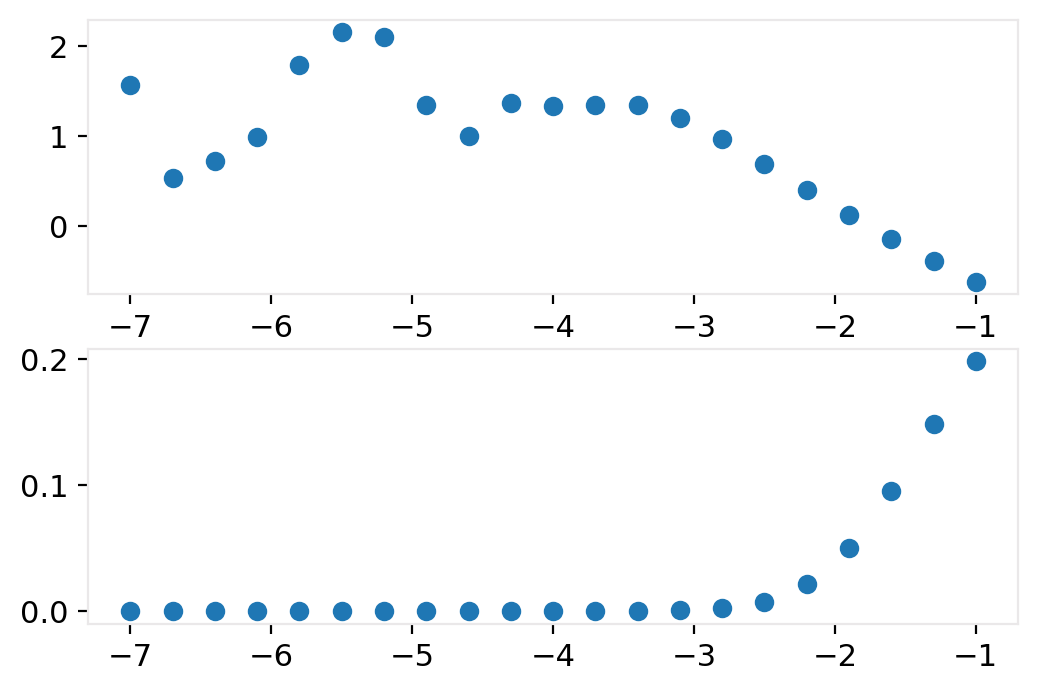

In [12]:
fig, axes = plt.subplots(2,1,dpi=200)
axes[0].scatter(np.log10(lambda_list), np.log10(P), label="P")
axes[1].scatter(np.log10(lambda_list), error, label="Ts")

Following the $\lambda$ suggested by P, detailed discussed in [J. Chem. Phys. 129, 194102 (2008)](https://doi.org/10.1063/1.2982799).

In [13]:
lambda_list[14]

6.30957344480193e-06

In [15]:
# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
ine.v_pbs = np.zeros_like(ine.v_pbs)
ine.invert("PDECO", opt_method="BFGS", opt_max_iter=500,
           guide_components="fermi_amaldi", reg=lambda_list[14], gtol=1e-6)

Optimization Successful within 499 iterations! |grad|=1.66e-06.


In [18]:
vrest_P = ine.eng.grid.ao(ine.v_pbs, grid=grid, basis=ine.eng.pbs)
vxc_P = vFA + vrest_P - vH

Following the $\lambda$ suggested by Ts (the edge of the L curve in the bottom panel)

In [20]:
lambda_list[6]

0.001584893192461114

In [21]:
# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
ine.v_pbs = np.zeros_like(ine.v_pbs)
ine.invert("PDECO", opt_method="BFGS", opt_max_iter=500,
           guide_components="fermi_amaldi", reg=lambda_list[6], gtol=1e-6)

Optimization Successful within 130 iterations! |grad|=2.18e-06.


In [28]:
vrest_Ts = ine.eng.grid.ao(ine.v_pbs, grid=grid, basis=ine.eng.pbs)
vxc_Ts = vFA + vrest_Ts - vH

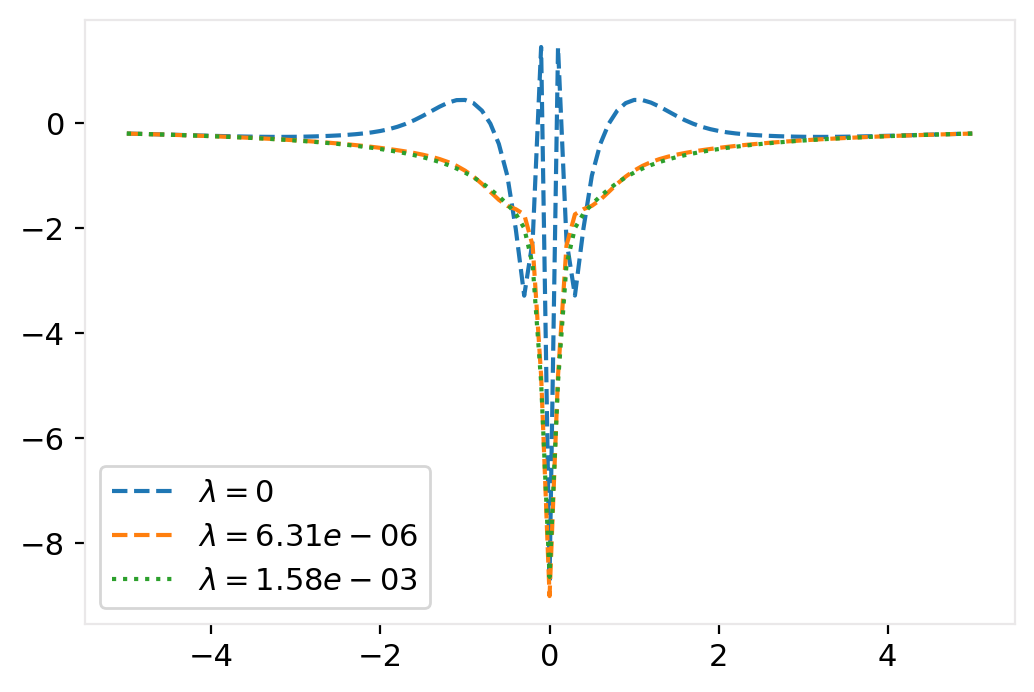

In [29]:
fig, ax = plt.subplots(dpi=200)
# ax.plot(xyz, vxc_exact, label="exact")
ax.plot(x, vxc, label="$\lambda=0$", ls='--')
ax.plot(x, vxc_P, label="$\lambda=%.2e$"%lambda_list[14], ls='--')
ax.plot(x, vxc_Ts, label="$\lambda=%.2e$"%lambda_list[6], ls=':')
ax.legend()